Setup

In [5]:
import os
import sys
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output

In [3]:
def dataset_path(path):
  cwd = os.getcwd()
  return os.path.join(cwd, '../../datasets', path)

In [4]:
def show_cv2_image(image, title='image'):
  plt.figure()
  plt.title(title)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Get Images

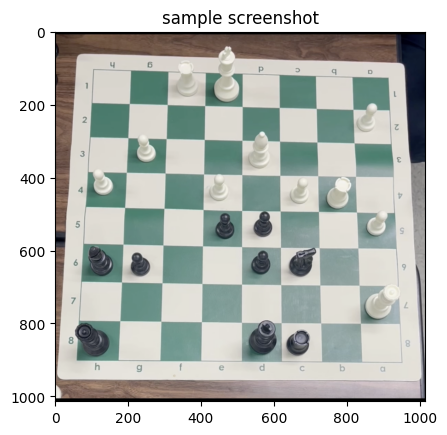

In [7]:
show_cv2_image(cv2.imread(dataset_path('sample_chess.png')), "sample screenshot")

OCR

In [24]:
def ocr_image(image):
  d = pytesseract.image_to_data(image, output_type=Output.DICT, config=("-c tessedit"
                  "_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
                  " --psm 6"
                  " -l osd"
                  " "))
  
  return d

In [25]:
ocr_image(cv2.imread(dataset_path('crop_scaled.png')))

{'level': [1, 2, 3, 4, 5, 4, 5],
 'page_num': [1, 1, 1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1, 2, 2],
 'word_num': [0, 0, 0, 0, 1, 0, 1],
 'left': [0, 236, 236, 236, 236, 632, 632],
 'top': [0, 305, 305, 305, 305, 695, 695],
 'width': [1016, 473, 473, 77, 77, 77, 77],
 'height': [1014, 506, 506, 110, 110, 116, 116],
 'conf': [-1, -1, -1, -1, 67, -1, 82],
 'text': ['', '', '', '', '8', '', 'h']}

In [18]:
def draw_box(image, x, y, w, h):
  cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

In [58]:
def show_image_with_ocr(image):
  result = ocr_image(image)
  
  if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  

  for i in range(len(result['text'])):
    if int(result['conf'][i]) > 0:
      x = result['left'][i]
      y = result['top'][i]
      w = result['width'][i]
      h = result['height'][i]
      draw_box(image, x, y, w, h)

  show_cv2_image(image, "ocr result")
  
def show_image_with_ocr_labelled(image):
  result = ocr_image(image)
  
  if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  
  for i in range(len(result['text'])):
    if int(result['conf'][i]) > 0:
      x = result['left'][i]
      y = result['top'][i]
      w = result['width'][i]
      h = result['height'][i]
      draw_box(image, x, y, w, h)
      cv2.putText(image, result['text'][i], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
  
  show_cv2_image(image, "ocr result")

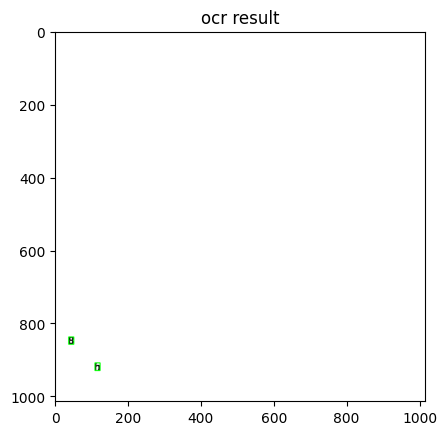

In [30]:
show_image_with_ocr(dataset_path('only_numbers.png'))

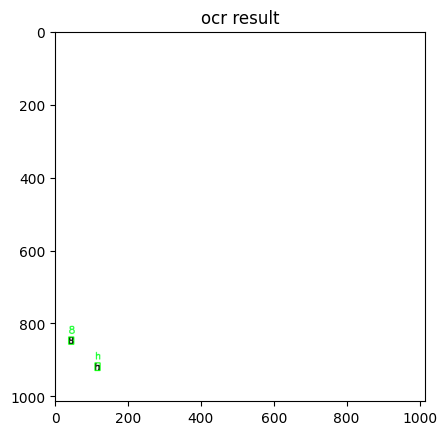

In [61]:
show_image_with_ocr_labelled(cv2.imread(dataset_path('only_numbers.png')))

OCR With Our Images

In [74]:
# Function to compute the intersection of two lines
def compute_intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2

    # Calculate the intersection of two lines
    A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])

    # Solve the linear system to find the intersection point
    intersection = np.linalg.solve(A, b)
    return int(intersection[0]), int(intersection[1])

In [76]:
def draw_black_board_boundaries(image):
  # Convert the image to HSV color space
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Define the range of green color in HSV
  lower_green = np.array([40, 25, 40])   # Lower bound of green in HSV
  upper_green = np.array([100, 200, 200]) # Upper bound of green in HSV

  # Threshold the image to get only the green color
  mask = cv2.inRange(hsv, lower_green, upper_green)

  # Find contours
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Create a black canvas to draw contours
  contour_image = np.zeros_like(mask)

  # Draw the contours on the black canvas (255 for white contours)
  cv2.drawContours(contour_image, contours, -1, (255), 1)

  # Apply the Canny edge detector on the contour image
  edges = cv2.Canny(contour_image, 50, 150, apertureSize=3)

  # Apply Hough Line Transform to find lines in the edge-detected image
  lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

  # Separate the lines into vertical and horizontal based on their angle (theta)
  vertical_lines = []
  horizontal_lines = []

  # Find vertical and horizontal lines
  if lines is not None:
    for rho, theta in lines[:, 0]:
      # Identify vertical lines (theta near 0 or 180 degrees)
      if np.abs(theta) < np.pi / 180 * 10 or np.abs(theta - np.pi) < np.pi / 180 * 10:
        vertical_lines.append((rho, theta))
      # Identify horizontal lines (theta near 90 degrees)
      elif np.abs(theta - np.pi / 2) < np.pi / 180 * 10:
        horizontal_lines.append((rho, theta))

  # Create an empty list to store intersection points
  intersection_points = []

  # Find intersection points between vertical and horizontal lines
  for v_line in vertical_lines:
    for h_line in horizontal_lines:
      intersection = compute_intersection(v_line, h_line)
      intersection_points.append(intersection)

  # Create an empty image to draw the intersection points
  intersection_image = np.zeros_like(image)

  # Draw the intersection points on the image (red points)
  for point in intersection_points:
    cv2.circle(intersection_image, point, 10, (0, 0, 255), -1)  # Red circle at intersection points

  # Convert the intersection image to grayscale
  grayscale_image = cv2.cvtColor(intersection_image, cv2.COLOR_BGR2GRAY)

  # Find contours of the red intersection points (non-zero pixels)
  contours, _ = cv2.findContours(grayscale_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Create an empty black image to draw the center points
  center_image = np.copy(image)

  # List to store the center points' coordinates
  center_points = []

  # Iterate over each contour and find the centroid (center point)
  for contour in contours:
    # Calculate the moments of the contour
    moments = cv2.moments(contour)
    
    # Calculate the centroid (center) of the contour
    if moments['m00'] != 0:
      cx = int(moments['m10'] / moments['m00'])
      cy = int(moments['m01'] / moments['m00'])
      
      # Draw the center point (blue) on the original image
      cv2.circle(center_image, (cx, cy), 5, (255, 0, 0), -1)  # Blue circle at center
      
      # Store the center coordinates in the list
      center_points.append((cx, cy))
  center_points = sorted(center_points, key=lambda x: sum(x))

  # Step 1: Find the convex hull of the center points
  center_points_np = np.array(center_points, dtype=np.int32)  # Convert to NumPy array
  hull = cv2.convexHull(center_points_np)  # Compute convex hull

  # Step 2: Create a mask for the filled polygon
  mask = np.zeros_like(image, dtype=np.uint8)  # Create a ~~black~~ white mask with the same dimensions as the image
  cv2.fillPoly(mask, [hull], (255, 255, 255))  # Draw the filled polygon on the mask

  # Step 3: Invert the mask to isolate the region outside the polygon
  inverted_mask = cv2.bitwise_not(mask)  # Invert the mask (white becomes black and vice versa)

  # Step 4: Apply the inverted mask to the original image
  result_image = cv2.bitwise_and(image, inverted_mask)  # Keep the border as in the original image

  return result_image

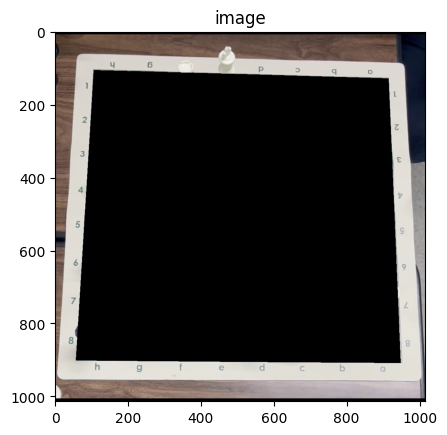

In [78]:
show_cv2_image(draw_black_board_boundaries(cv2.imread(dataset_path('sample_chess.png'))))

In [87]:
def draw_white_board_boundaries(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range of green color in HSV
    lower_green = np.array([40, 25, 40])  # Lower bound of green in HSV
    upper_green = np.array([100, 200, 200])  # Upper bound of green in HSV

    # Threshold the image to get only the green color
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a black canvas to draw contours
    contour_image = np.zeros_like(mask)

    # Draw the contours on the black canvas (255 for white contours)
    cv2.drawContours(contour_image, contours, -1, (255), 1)

    # Apply the Canny edge detector on the contour image
    edges = cv2.Canny(contour_image, 50, 150, apertureSize=3)

    # Apply Hough Line Transform to find lines in the edge-detected image
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    # Separate the lines into vertical and horizontal based on their angle (theta)
    vertical_lines = []
    horizontal_lines = []

    # Find vertical and horizontal lines
    if lines is not None:
        for rho, theta in lines[:, 0]:
            # Identify vertical lines (theta near 0 or 180 degrees)
            if np.abs(theta) < np.pi / 180 * 10 or np.abs(theta - np.pi) < np.pi / 180 * 10:
                vertical_lines.append((rho, theta))
            # Identify horizontal lines (theta near 90 degrees)
            elif np.abs(theta - np.pi / 2) < np.pi / 180 * 10:
                horizontal_lines.append((rho, theta))

    # Create an empty list to store intersection points
    intersection_points = []

    # Find intersection points between vertical and horizontal lines
    for v_line in vertical_lines:
        for h_line in horizontal_lines:
            intersection = compute_intersection(v_line, h_line)
            intersection_points.append(intersection)

    # Create an empty image to draw the intersection points
    intersection_image = np.zeros_like(image)

    # Draw the intersection points on the image (red points)
    for point in intersection_points:
        cv2.circle(intersection_image, point, 10, (0, 0, 255), -1)  # Red circle at intersection points

    # Convert the intersection image to grayscale
    grayscale_image = cv2.cvtColor(intersection_image, cv2.COLOR_BGR2GRAY)

    # Find contours of the red intersection points (non-zero pixels)
    contours, _ = cv2.findContours(grayscale_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty black image to draw the center points
    center_image = np.copy(image)

    # List to store the center points' coordinates
    center_points = []

    # Iterate over each contour and find the centroid (center point)
    for contour in contours:
        # Calculate the moments of the contour
        moments = cv2.moments(contour)
        
        # Calculate the centroid (center) of the contour
        if moments['m00'] != 0:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
            
            # Draw the center point (blue) on the original image
            cv2.circle(center_image, (cx, cy), 5, (255, 0, 0), -1)  # Blue circle at center
            
            # Store the center coordinates in the list
            center_points.append((cx, cy))
    center_points = sorted(center_points, key=lambda x: sum(x))

    # Step 1: Find the convex hull of the center points
    center_points_np = np.array(center_points, dtype=np.int32)  # Convert to NumPy array
    hull = cv2.convexHull(center_points_np)  # Compute convex hull

    # Step 2: Create a mask for the filled polygon
    mask = np.ones_like(image, dtype=np.uint8) * 255  # Create a white mask with the same dimensions as the image
    cv2.fillPoly(mask, [hull], (0, 0, 0))  # Draw the filled polygon in black on the mask
    
    image[mask == 0] = 255
    result_image = image

    return result_image


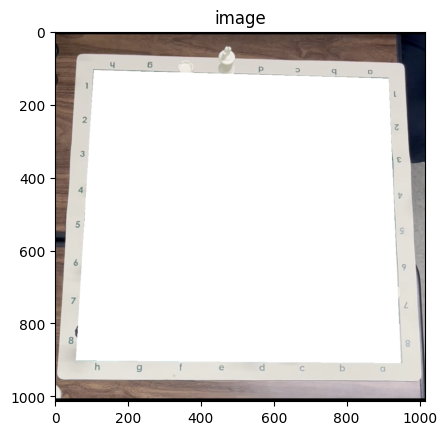

In [88]:
show_cv2_image(draw_white_board_boundaries(cv2.imread(dataset_path('sample_chess.png'))))

In [117]:
def process_image(image):
  processed_image = draw_white_board_boundaries(image)
  
  result = processed_image
  return result

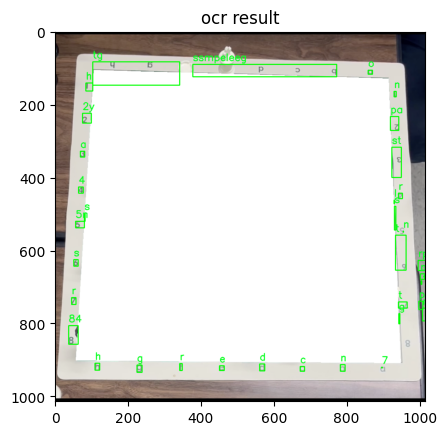

In [118]:
show_image_with_ocr_labelled(process_image(cv2.imread(dataset_path('sample_chess.png'))))

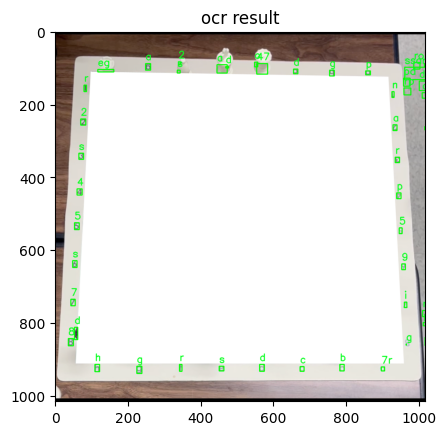

In [161]:
show_image_with_ocr_labelled(cv2.imread(dataset_path('white_overlay.png')))

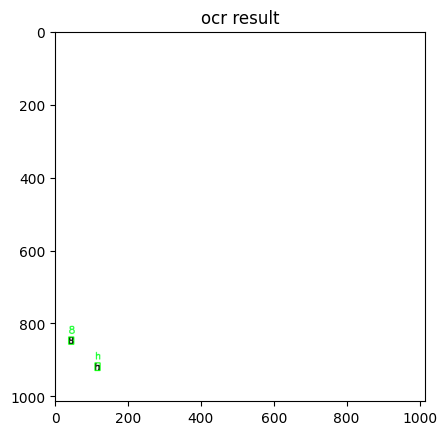

In [160]:
show_image_with_ocr_labelled(cv2.imread(dataset_path('only_numbers.png')))

detect chessboard orientation

In [151]:
# ORIENTATIONS
#   'UPRIGHT' => 8 is top-left, h is bottom-right
#   'ROTATED_RIGHT' => # 8 is top-right, h is bottom-left
#   'UPSIDE_DOWN' => 8 is bottom-right, h is top-left
#   'ROTATED_LEFT' => 8 is bottom-left, h is top-right
# }

def bounding_box(left, top, width, height):
  return [(left, top), (left + width, top), (left + width, top + height), (left, top + height)]

def draw_bounding_box(image, box, color=(0, 255, 0)):
  cv2.polylines(image, [np.array(box)], isClosed=True, color=color, thickness=2)
  return image

def get_board_orientation(bound_8, bound_h):
  # compute the center of the two bounding boxes
  center_8 = np.mean(np.array(bound_8), axis=0)
  center_h = np.mean(np.array(bound_h), axis=0)
  
  # check the relative position of the two centers
  if center_8[0] < center_h[0] and center_8[1] < center_h[1]:
    return 'UPRIGHT'
  elif center_8[0] > center_h[0] and center_8[1] > center_h[1]:
    return 'UPSIDE_DOWN'
  elif center_8[0] < center_h[0] and center_8[1] > center_h[1]:
    return 'ROTATED_RIGHT'
  elif center_8[0] > center_h[0] and center_8[1] < center_h[1]:
    return 'ROTATED_LEFT'
  

def detect_chessboard_orientation(image):
  data = ocr_image(image)
  
  print(f'Detected text: {data['text']}')
  
  bounds_8 = [] # sample: [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
  bounds_h = [] # sample: [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
  
  for i in range(len(data['text'])):
    if data['text'][i] == '8':
      # store the bounding box of the 8
      bounds_8.append(bounding_box(data['left'][i], data['top'][i], data['width'][i], data['height'][i]))
    elif data['text'][i] == 'h':
      bounds_h.append(bounding_box(data['left'][i], data['top'][i], data['width'][i], data['height'][i]))
  
  # find the closest pair of 8 and h
  closest = None
  
  for bound_8 in bounds_8:
    for bound_h in bounds_h:
      distance = np.linalg.norm(np.array(bound_8) - np.array(bound_h))
      
      if closest is None or distance < closest[0]:
        closest = (distance, bound_8, bound_h)
        
  print(f'Closest pair: {closest}')
  
  if closest is None:
    return False, closest
  
  # compute the center of the two bounding boxes
  center_8 = np.mean(np.array(closest[1]), axis=0)
  center_h = np.mean(np.array(closest[2]), axis=0)
  
  # draw the line between the two points
  cv2.line(image, tuple(center_8.astype(int)), tuple(center_h.astype(int)), (255, 0, 0), 2)
  
  # draw the bounding boxes
  image = draw_bounding_box(image, bound_8, (0, 255, 0))
  image = draw_bounding_box(image, bound_h, (0, 0, 255))
  
  show_cv2_image(image, "detected image")
    
  return get_board_orientation(closest[1], closest[2]), closest

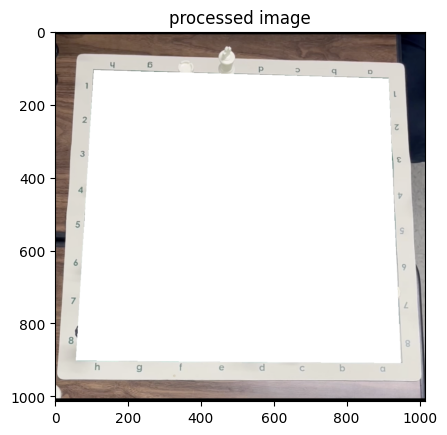

In [152]:
show_cv2_image(process_image(cv2.imread(dataset_path('sample_chess.png'))), "processed image")

In [153]:
detect_chessboard_orientation(process_image(cv2.imread(dataset_path('sample_chess.png'))))

Detected text: ['', '', '', '', 'tg', 'ssmpeleeg', 'o', '', 'h', 'n', '', '2y', 'pa', '', 'a', 'st', '', '4', 'r', '', 'l', '', 's', 's', '', '5n', 'n', '', 's', 't', 'rp', '', 'm', '', '7', '', 'r', 't', 'p', '', 'g', 'rr', '', '84', '', 'h', 'g', 'r', 'e', 'd', 'c', 'n', '7']
Closest pair: None


(False, None)

Detected text: ['', '', '', '', '8', '', 'h']
Closest pair: (np.float64(202.94334184693028), [(37, 838), (51, 838), (51, 858), (37, 858)], [(109, 909), (123, 909), (123, 930), (109, 930)])


('UPRIGHT',
 (np.float64(202.94334184693028),
  [(37, 838), (51, 838), (51, 858), (37, 858)],
  [(109, 909), (123, 909), (123, 930), (109, 930)]))

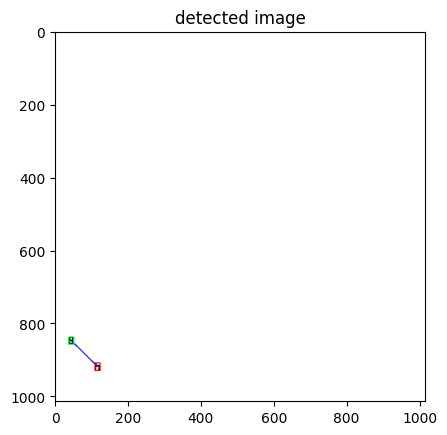

In [154]:
detect_chessboard_orientation(cv2.imread(dataset_path('only_numbers.png')))

In [155]:
def rotate_test(image):
  images = [image]
  # rotate
  image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
  images.append(image)

  # flip
  image = cv2.flip(image, 1)
  images.append(image)

  # rotate
  image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

  images.append(image)
  
  has_detected = False
  # detect orientation
  for i, image in enumerate(images):
    result = detect_chessboard_orientation(process_image(image))
    if result[0]:
      has_detected = True
      
  if not has_detected:
    show_image_with_ocr_labelled(images[0])
    
  

In [156]:
image_paths = glob.glob(dataset_path('chess/*'))

Detected text: ['', '', '', '', 'r', 'w', 'r', 'r', '', '', '7', '4', 's', '4', 's', 'ni', 'd', 'g', 'o4', 'ggs', '', 'arg', '', '', 'nr', 'u', 'opngps', '', '', 'l', 'n', 'rsssi', '', '', 'n', 's', 'tg', 'sla', '', '', 'y', 'l', 'p', 'ss', '', '', 'g', 'l', 'd', 'g', '', '', '2', 'ur', 'r', 'ny', '', '', 'l', 'gnd', '', '', 'n', 'oun', '', '', 's', 'dar', '', '', 's', 'd', '', '4', 'np', 'u', '', '', '3', 'ugg', '', '', 'n', 'pg', '', 'sn', 'r', 'g', '', '', '7', '29', 't', '', '', 'n', 'n', 'sn', '', '', '7l', 'y', 'g', '', '', 'h', 'g', 'eer', 's', 'd', 'r', 'eerrm', 'r']
Closest pair: None
Detected text: ['', '', '', '', 'm', 'sm', '', 'ueess', 'd', 'u', '', '8esg', 'a', 'gu', 'ri', 's', '', 'r', 'd', '', 't', '', 'o', 'g', '', 'u', '', 'sg', 'r', 's', '', 'm', 'ro', '', 'un', '', 's', 'a', 'rg', '', '5', '', 'u', '', 'g', '', 'n', 'y', 'p', '', '3', '', 'd', '', 'g', '', 'ess24', '', 'y', 'Tr', 'gse', 'm', 'd', 'p', '', 'gr', 's', 'd', 'p']
Closest pair: None
Detected text: ['', '

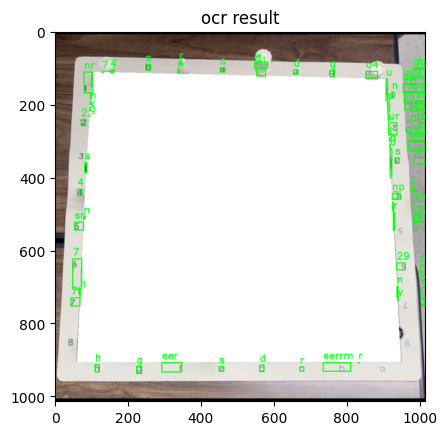

In [157]:
rotate_test(cv2.imread(image_paths[0]))

The final test

Detected text: ['', '', '', '', 'r', 'w', 'r', 'r', '', '', '7', '4', 's', '4', 's', 'ni', 'd', 'g', 'o4', 'ggs', '', 'arg', '', '', 'nr', 'u', 'opngps', '', '', 'l', 'n', 'rsssi', '', '', 'n', 's', 'tg', 'sla', '', '', 'y', 'l', 'p', 'ss', '', '', 'g', 'l', 'd', 'g', '', '', '2', 'ur', 'r', 'ny', '', '', 'l', 'gnd', '', '', 'n', 'oun', '', '', 's', 'dar', '', '', 's', 'd', '', '4', 'np', 'u', '', '', '3', 'ugg', '', '', 'n', 'pg', '', 'sn', 'r', 'g', '', '', '7', '29', 't', '', '', 'n', 'n', 'sn', '', '', '7l', 'y', 'g', '', '', 'h', 'g', 'eer', 's', 'd', 'r', 'eerrm', 'r']
Closest pair: None
Detected text: ['', '', '', '', 'm', 'sm', '', 'ueess', 'd', 'u', '', '8esg', 'a', 'gu', 'ri', 's', '', 'r', 'd', '', 't', '', 'o', 'g', '', 'u', '', 'sg', 'r', 's', '', 'm', 'ro', '', 'un', '', 's', 'a', 'rg', '', '5', '', 'u', '', 'g', '', 'n', 'y', 'p', '', '3', '', 'd', '', 'g', '', 'ess24', '', 'y', 'Tr', 'gse', 'm', 'd', 'p', '', 'gr', 's', 'd', 'p']
Closest pair: None
Detected text: ['', '

/var/folders/zs/v7v__8pn45dc699tr5rpqxkw0000gn/T/ipykernel_69174/379158312.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Detected text: ['', '', '', '', 'w', 'sa', '', 'degeeee', 'd', 'm', '', '7seeeenas', 'd', 'eg', 'n', 'd', '', 'r', 'd', '', 't', '', 'm', '', 'n', '', 'm', 'u', '4', '', 'p', '', 't', 'n', '', 'go', '', '3', 'g', 'ms', '', 'l', '', 'so', '', 'l', 'd', '', 'n', '', '3', '', 'p', '', 'o', '', 't', '', 'l', 'p', '', 'm', 'd', 'grrgudes', 'n', 'u', 'p', 'r', '', 'pp', 'p', '3n', 'dd', '8', '', 'h', 'ig', '4', '4', 'p', 'm', 'mrrss', 'g', 'Sss', 'nys', 'g', 'n']
Closest pair: (np.float64(1663.1885040487743), [(881, 961), (890, 961), (890, 971), (881, 971)], [(53, 961), (55, 961), (55, 988), (53, 988)])
Detected text: ['', '', '', '', 'p', 'ao', '', 'ru', 'd', 'u', '7e', 'g', 'per', '', 'h', 'u', 'pu', '4', 'arr', 'uag', '', 'cgssr', '', 't', '', 'm', '', 'o', '', 'p', 'ly', '', 'ad', 'm', '', 'u', 'da', '', 'n', 'g', '', 'u', '', 'r', 'l', '', 'l', '', 'm', 'l', '', 'o', '', 'd', '', 'sns', 'P', 'n', '', 'n', 'm', 'p', 'ur', 'og', '', 'r', 'dgru', 'r', '46', '', 'n', 'nr', 'gg', 'ptdr', 'o'

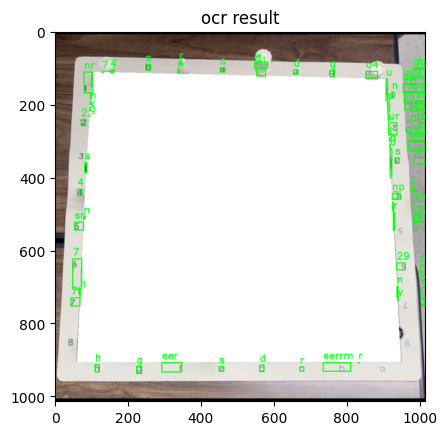

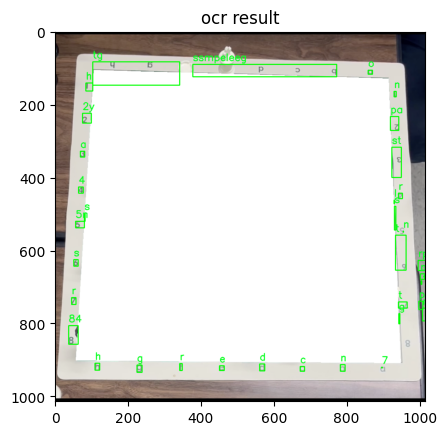

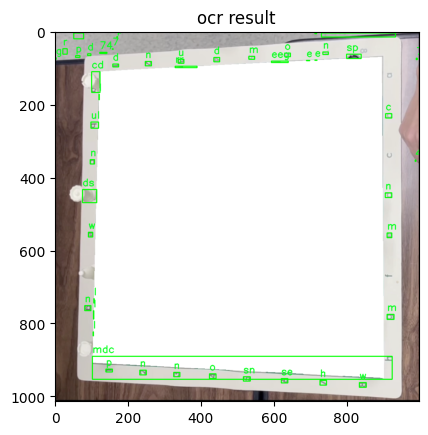

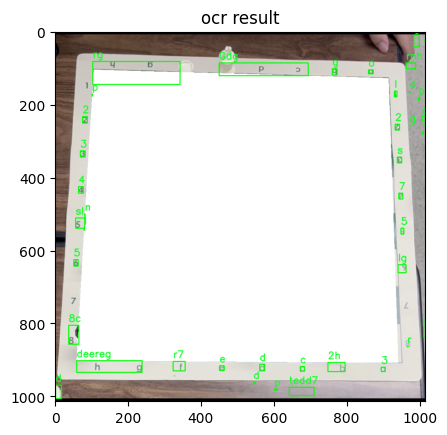

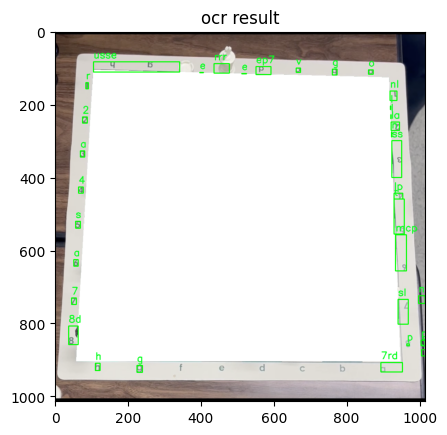

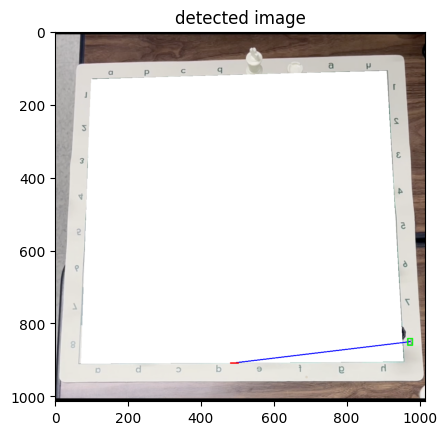

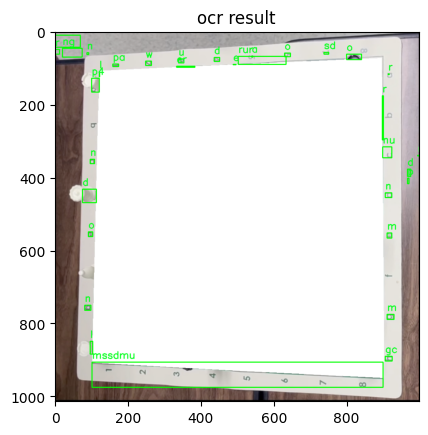

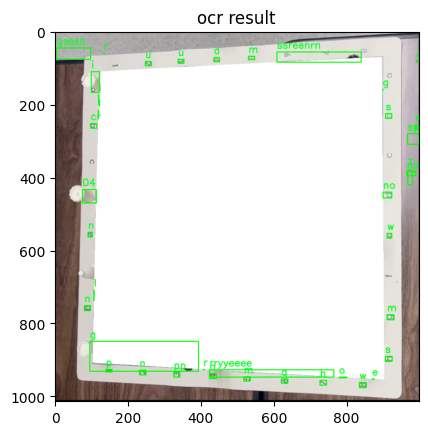

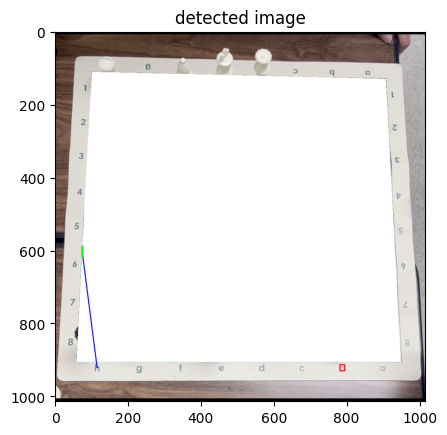

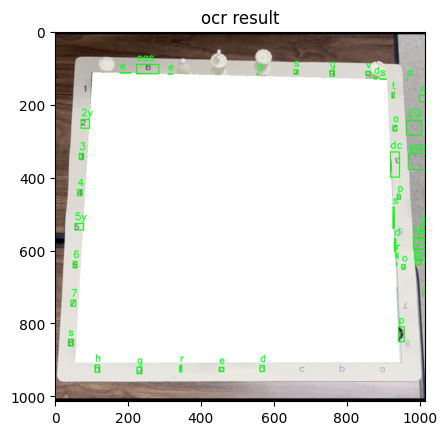

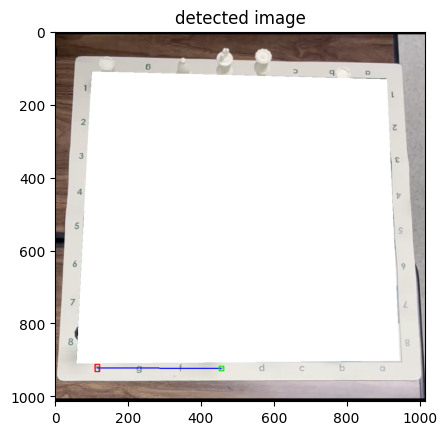

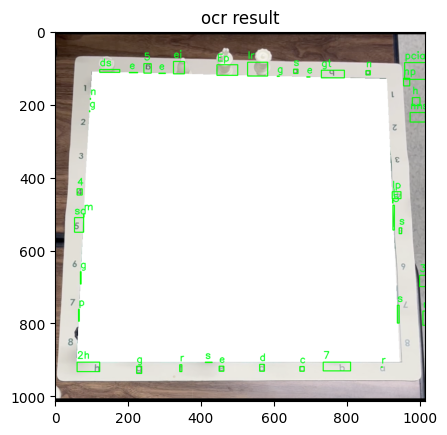

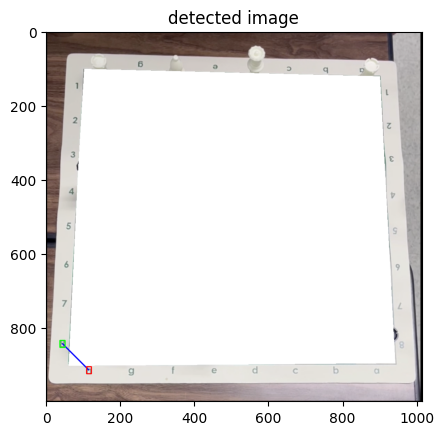

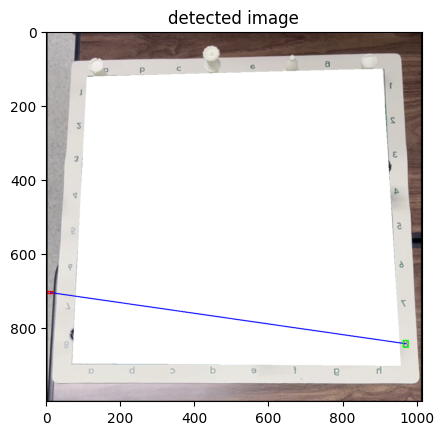

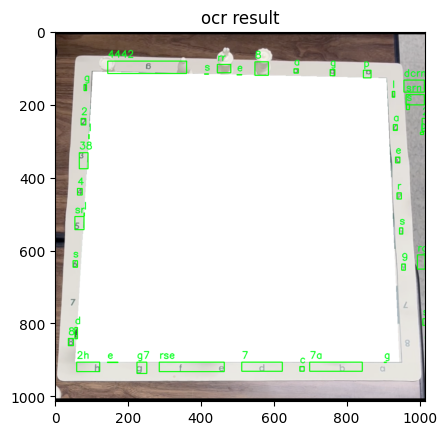

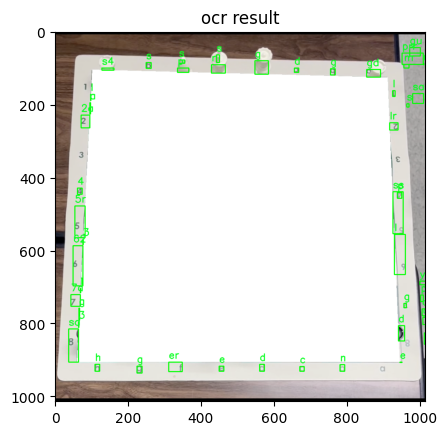

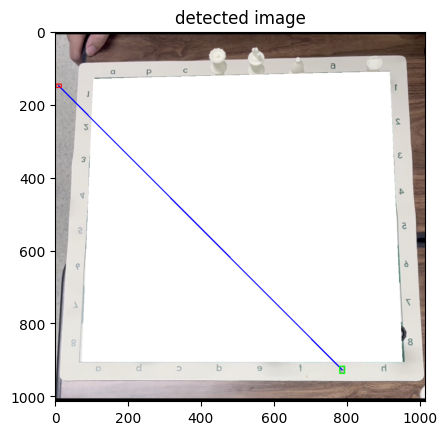

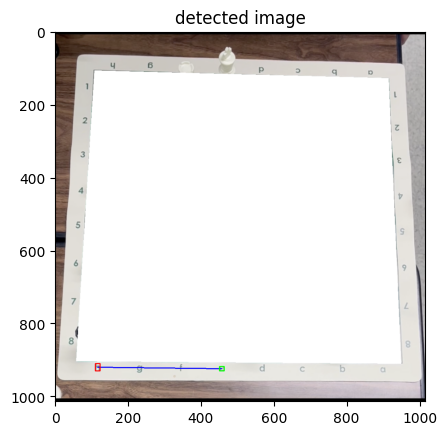

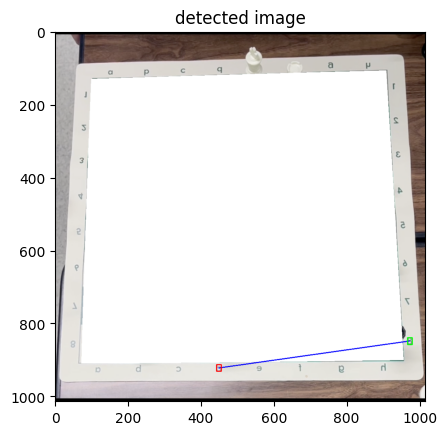

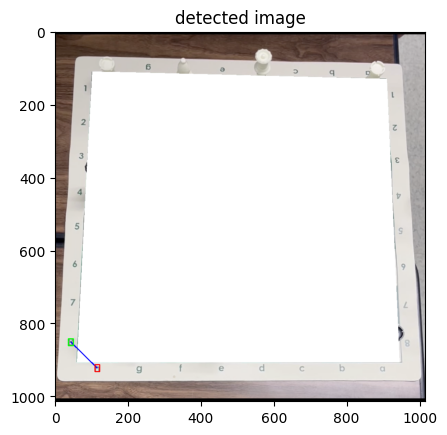

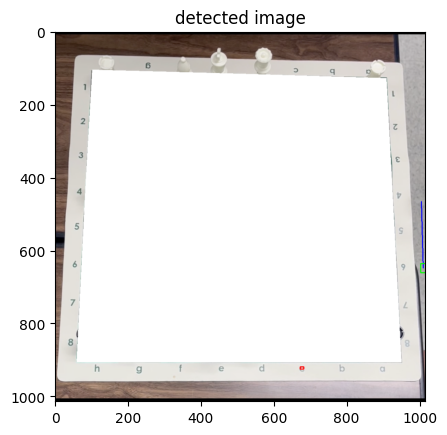

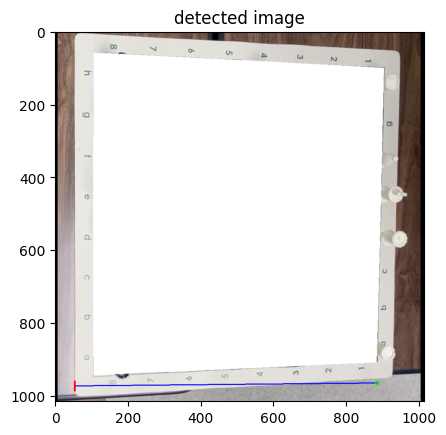

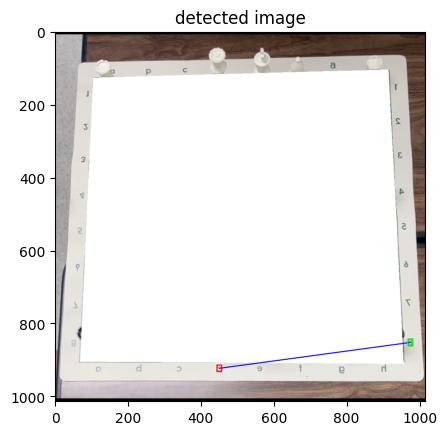

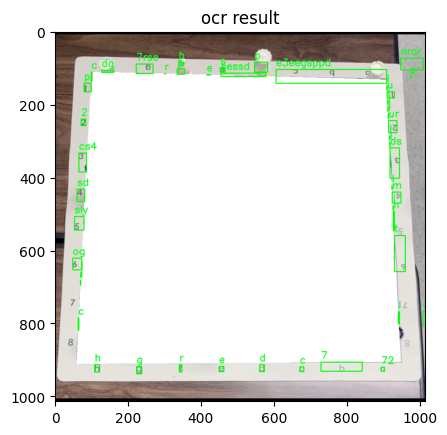

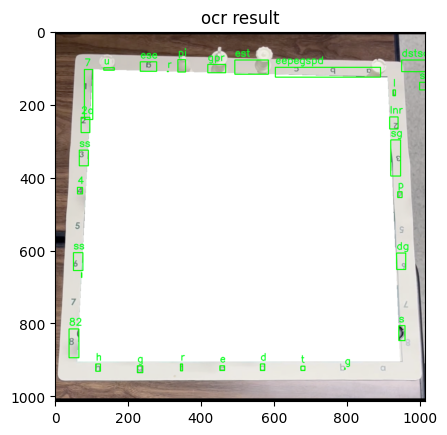

In [158]:
for image_path in image_paths:
  image = cv2.imread(image_path)
  rotate_test(image)